## Data Info

########################################

The ExtraSensory Dataset

Primary data files (features and labels)

########################################

The ExtraSensory Dataset was collected by
Yonatan Vaizman and Katherine Ellis, with the supervision of Gert Lanckriet.
Department of Electrical and Computer Engineering,
University of California, San Diego.

The dataset is publicly available.
Any usage of the dataset for publications requires citing the official paper that introduced the dataset:
Vaizman, Y., Ellis, K., and Lanckriet, G. "Recognizing Detailed Human Context In-the-Wild from Smartphones and Smartwatches".
IEEE Pervasive Computing, vol. 16, no. 4, October-December 2017, pp. 62-74. doi:10.1109/MPRV.2017.3971131
(In the website, we refer to this original paper as Vaizman2017a)

########################################

Content of the primary data files:
There are 60 'csv.gz' files, one for each participant (user, subject) in the data collection.
Each of these files has filename with the form:
[UUID].features_labels.csv.gz
where each user has a unique (randomly generated) universal user identification (UUID) number.
Each file is a textual CSV file, compressed using the gzip format.

Within every user's CSV file:
-----------------------------
- The first row specifies the columns of the file.
- Every other row refers to an example from the user. The examples are sorted according to the primary key - the timestamp.
- The columns:

-- First column is 'timestamp'. This is represented as standard number of seconds since the epoch.

-- Second, come columns for the extracted features.
   Unavailable features are represented with 'nan'.
   The name of each feature contains reference to the sensor it was extracted from, in the form [sensor_name]:[feature_name].
   The current version contains features from the following sensors, with sensor names:
--- raw_acc: Accelerometer from the phone. The 'raw' version of acceleration (as opposed to the decomposed versions of gravity and user-acceleration).   
--- proc_gyro: Gyroscope from the phone. Processed version of gyroscope measurements (the OS calculates a version that removes drift).
--- raw_magnet: Magnetometer from the phone. Raw version (as opposed to bias-fixed version that the OS also provides).
--- watch_acceleration: Accelerometer from the watch.
--- watch_heading: Heading from the compass on the watch.
--- location: Location services. These features were extracted offline for every example from the sequence of latitude-longitude-altitude updates from the example's minute.
              These features regard only to relative-location (not absolute location in the world) - meaning, they describe variability of movement within the minute.
--- location_quick_features: Location services. These features were calculated on the phone when data was collected. 
                             These are available even in cases that the other location features are not because the user wanted to conceal their absolute location coordinates.
							 These quick features are very simple heuristics that approximate the more thoughtful offline features.
--- audio_naive: Microphone. These naive features are simply averages and standard deviations of the 13 MFCCs from the ~20sec recording window of every example.
--- discrete: Phone-state. These are binary indicators for the state of the phone.
              Notice that time_of_day features are also considered phone-state features (also have prefix 'discrete:'), but their columns appear not right after the other 'discrete' columns.
--- lf_measurements: Various sensors that were recorded in low-frequency (meaning, once per example).

-- Third, come columns for the ground truth labels.
   The values are either 1 (label is relevant for the example), 0 (label is not relevant for the example), or 'nan' (label is considered 'missing' for this example).
   Originally, users could only report 'positive' labels (in the original ExtraSensory paper, Vaizman2017a, we assumed that when a label was not reported it is a 'negative' example).
   This cleaned version of the labels has the notion of 'missing labels'; Details about how we inferred missing label information is provided in the second paper, Vaizman2017b (see http://extrasensory.ucsd.edu for updated references).
   The names of the labels have prefix 'label:'. After the prefix:
   If the label name is all capitalized, it is an original label from the mobile app's interface and the values were taken from what the user originally reported.
   If the label name begins with 'FIX_', this is a fixes/cleaned version of a corresponding label, meaning that the researchers fixed some of the values that were reported by users because of inconsistencies.
   If the label name begins with 'OR_', this is a synthesized label, meaning it did not appear in the app's label menu, but rather the researchers created it as combination (using logical or) of other related labels.
   If the label name begins with 'LOC_', this is a fixed/cleaned version of a corresponding label that was fixed by researchers based on absolute location.
      LOC_beach was based on original label 'AT_THE_BEACH'.
	  LOC_home was based on original label 'AT_HOME'.
	  LOC_main_workplace was based on original label 'AT_WORK'.

-- Fourth, the last column is label_source, describing where the original labeling came from in the mobile app's interface. It has 8 possible values:
   -1: The user did not report any labels for this example (notice, however, that this example may still have labeling for the 'LOC_' labels).
   0 : The user used the 'active feedback' interface (reporting immediate future). This example is the first in relevant minute sequence.
   1 : The user used the 'active feedback' interface. This example is a continuation of a sequence of minutes since the user started the reported context.
   2 : The user used the history interface to label an example from the past.
   3 : The user replied to a notification that simply asked to provide any labels.
   4 : The user replied to a notification that asked 'In the past [minutes] minutes were you still [recent context]?'. The user replied 'correct' on the phone.
   5 : The user replied to a notification that asked 'In the past [minutes] minutes were you still [recent context]?'. The user replied 'not exactly' and then corrected the context labels.
   6 : The user replied to a notification that asked 'In the past [minutes] minutes were you still [recent context]?'. The user replied 'correct' on the watch interface.


########################################

## Data Consolidation
Getting the data from all the different files into one csv.

In [1]:
import zipfile
import os
import gzip
import shutil
import pandas as pd
import numpy as np
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# Making sure ExtraSensory.per_uuid_features_labels.zip exists and is unziped

# Path of the zip file
zip_file = 'ExtraSensory.per_uuid_features_labels.zip'

# Extract to the directory obtained from the zip file name
zip_extract_to = zip_file.replace('.zip', '')

# Unzipping
if os.path.exists(zip_file):
    if not os.path.exists(zip_extract_to):
        os.makedirs(zip_extract_to)
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(zip_extract_to)
        message = "Unzipped successfully."
    else:
        message = "Directory already exists. File might be unzipped."
else:
    message = "Zip file not found."

message

'Directory already exists. File might be unzipped.'

In [3]:
# Improved variable name for the directory where the extracted files will be saved
unzipped_data_dir = f"{zip_extract_to}-Unzipped"

# Create the unzipped data directory if it does not exist
if not os.path.exists(unzipped_data_dir):
    os.makedirs(unzipped_data_dir)

# Extracting .csv.gz files
extraction_message = ""
if os.path.exists(zip_extract_to):
    for file in os.listdir(zip_extract_to):
        if file.endswith('.gz'):
            gz_file_path = os.path.join(zip_extract_to, file)
            csv_file_path = os.path.join(unzipped_data_dir, file[:-3])  # Removing '.gz' from filename

            try:
                with gzip.open(gz_file_path, 'rb') as f_in:
                    with open(csv_file_path, 'wb') as f_out:
                        shutil.copyfileobj(f_in, f_out)
                extraction_message += f"Extracted {file}\n"
            except Exception as e:
                extraction_message += f"Error extracting {file}: {e}\n"
else:
    extraction_message = "Directory with .gz files not found."

print(extraction_message.strip())


Extracted A7599A50-24AE-46A6-8EA6-2576F1011D81.features_labels.csv.gz
Extracted 78A91A4E-4A51-4065-BDA7-94755F0BB3BB.features_labels.csv.gz
Extracted 11B5EC4D-4133-4289-B475-4E737182A406.features_labels.csv.gz
Extracted CDA3BBF7-6631-45E8-85BA-EEB416B32A3C.features_labels.csv.gz
Extracted CF722AA9-2533-4E51-9FEB-9EAC84EE9AAC.features_labels.csv.gz
Extracted 5152A2DF-FAF3-4BA8-9CA9-E66B32671A53.features_labels.csv.gz
Extracted A76A5AF5-5A93-4CF2-A16E-62353BB70E8A.features_labels.csv.gz
Extracted 665514DE-49DC-421F-8DCB-145D0B2609AD.features_labels.csv.gz
Extracted 83CF687B-7CEC-434B-9FE8-00C3D5799BE6.features_labels.csv.gz
Extracted 27E04243-B138-4F40-A164-F40B60165CF3.features_labels.csv.gz
Extracted 1538C99F-BA1E-4EFB-A949-6C7C47701B20.features_labels.csv.gz
Extracted 5EF64122-B513-46AE-BCF1-E62AAC285D2C.features_labels.csv.gz
Extracted 7D9BB102-A612-4E2A-8E22-3159752F55D8.features_labels.csv.gz
Extracted 33A85C34-CFE4-4732-9E73-0A7AC861B27A.features_labels.csv.gz
Extracted 74B86067-5

In [4]:
# Function to extract user_id from filename
def extract_user_id(filename):
    return filename.split('.')[0]

# Combining all CSVs into one dataframe
combined_csv_data = pd.DataFrame()

if os.path.exists(unzipped_data_dir):
    for file in os.listdir(unzipped_data_dir):
        if file.endswith('.csv'):
            file_path = os.path.join(unzipped_data_dir, file)
            user_id = extract_user_id(file)

            # Read the CSV file and add the user_id column
            csv_data = pd.read_csv(file_path)
            csv_data['user_id'] = user_id

            # Append to the combined dataframe
            combined_csv_data = pd.concat([combined_csv_data, csv_data], ignore_index=True)

            
            #print(f"Processed file: {file} \nCurrent size of combined data: {combined_csv_data.shape}")


    # Check if any data has been combined
    if not combined_csv_data.empty:
        # Save the combined CSV data to a file
        combined_csv_filename = os.path.join('ExtraSensory_Combined_User_Data.csv')
        combined_csv_data.to_csv(combined_csv_filename, index=False)
        print(f"Combined CSV file created at {combined_csv_filename}.")
    else:
        print("No CSV files found to combine or combined data is empty.")
else:
    print("Directory with unzipped CSV files not found.")


Combined CSV file created at ExtraSensory_Combined_User_Data.csv.


## Data Exploration

In [5]:
print(combined_csv_data.columns)

# user_id is for us to make sure we have record on source of the data. 
# TODO: For now. May be we can compare the data and relate it to timeseries

# Information not organized

Index(['timestamp', 'raw_acc:magnitude_stats:mean',
       'raw_acc:magnitude_stats:std', 'raw_acc:magnitude_stats:moment3',
       'raw_acc:magnitude_stats:moment4',
       'raw_acc:magnitude_stats:percentile25',
       'raw_acc:magnitude_stats:percentile50',
       'raw_acc:magnitude_stats:percentile75',
       'raw_acc:magnitude_stats:value_entropy',
       'raw_acc:magnitude_stats:time_entropy',
       ...
       'label:ELEVATOR', 'label:OR_standing', 'label:AT_SCHOOL',
       'label:PHONE_IN_HAND', 'label:PHONE_IN_BAG', 'label:PHONE_ON_TABLE',
       'label:WITH_CO-WORKERS', 'label:WITH_FRIENDS', 'label_source',
       'user_id'],
      dtype='object', length=279)


In [6]:
def build_hierarchy(columns):
    # Build a nested dictionary representing the hierarchy of columns.
    hierarchy = {}
    for col in columns:
        parts = col.split(':')
        current_level = hierarchy

        for part in parts[:-1]:
            current_level = current_level.setdefault(part, {})
        
        current_level[parts[-1]] = col

    return hierarchy

def format_hierarchy(hierarchy, indent=0):
    # Format the hierarchy into a readable string with indentation.
    result = ""
    for key, value in hierarchy.items():
        prefix = "  " * indent + "- "
        if isinstance(value, dict):
            result += f"{prefix}{key}:\n{format_hierarchy(value, indent + 1)}"
        else:
            result += f"{prefix} {key}\n"
    return result

# Building and formatting the hierarchy
hierarchy = build_hierarchy(combined_csv_data.columns)
formatted_hierarchy = format_hierarchy(hierarchy)
print(formatted_hierarchy)


-  timestamp
- raw_acc:
  - magnitude_stats:
    -  mean
    -  std
    -  moment3
    -  moment4
    -  percentile25
    -  percentile50
    -  percentile75
    -  value_entropy
    -  time_entropy
  - magnitude_spectrum:
    -  log_energy_band0
    -  log_energy_band1
    -  log_energy_band2
    -  log_energy_band3
    -  log_energy_band4
    -  spectral_entropy
  - magnitude_autocorrelation:
    -  period
    -  normalized_ac
  - 3d:
    -  mean_x
    -  mean_y
    -  mean_z
    -  std_x
    -  std_y
    -  std_z
    -  ro_xy
    -  ro_xz
    -  ro_yz
- proc_gyro:
  - magnitude_stats:
    -  mean
    -  std
    -  moment3
    -  moment4
    -  percentile25
    -  percentile50
    -  percentile75
    -  value_entropy
    -  time_entropy
  - magnitude_spectrum:
    -  log_energy_band0
    -  log_energy_band1
    -  log_energy_band2
    -  log_energy_band3
    -  log_energy_band4
    -  spectral_entropy
  - magnitude_autocorrelation:
    -  period
    -  normalized_ac
  - 3d:
    -  me

In [7]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
combined_csv_data.head()

,timestamp,raw_acc:magnitude_stats:mean,raw_acc:magnitude_stats:std,raw_acc:magnitude_stats:moment3,raw_acc:magnitude_stats:moment4,raw_acc:magnitude_stats:percentile25,raw_acc:magnitude_stats:percentile50,raw_acc:magnitude_stats:percentile75,raw_acc:magnitude_stats:value_entropy,raw_acc:magnitude_stats:time_entropy,raw_acc:magnitude_spectrum:log_energy_band0,raw_acc:magnitude_spectrum:log_energy_band1,raw_acc:magnitude_spectrum:log_energy_band2,raw_acc:magnitude_spectrum:log_energy_band3,raw_acc:magnitude_spectrum:log_energy_band4,raw_acc:magnitude_spectrum:spectral_entropy,raw_acc:magnitude_autocorrelation:period,raw_acc:magnitude_autocorrelation:normalized_ac,raw_acc:3d:mean_x,raw_acc:3d:mean_y,raw_acc:3d:mean_z,raw_acc:3d:std_x,raw_acc:3d:std_y,raw_acc:3d:std_z,raw_acc:3d:ro_xy,raw_acc:3d:ro_xz,raw_acc:3d:ro_yz,proc_gyro:magnitude_stats:mean,proc_gyro:magnitude_stats:std,proc_gyro:magnitude_stats:moment3,proc_gyro:magnitude_stats:moment4,proc_gyro:magnitude_stats:percentile25,proc_gyro:magnitude_stats:percentile50,proc_gyro:magnitude_stats:percentile75,proc_gyro:magnitude_stats:value_entropy,proc_gyro:magnitude_stats:time_entropy,proc_gyro:magnitude_spectrum:log_energy_band0,proc_gyro:magnitude_spectrum:log_energy_band1,proc_gyro:magnitude_spectrum:log_energy_band2,proc_gyro:magnitude_spectrum:log_energy_band3,proc_gyro:magnitude_spectrum:log_energy_band4,proc_gyro:magnitude_spectrum:spectral_entropy,proc_gyro:magnitude_autocorrelation:period,proc_gyro:magnitude_autocorrelation:normalized_ac,proc_gyro:3d:mean_x,proc_gyro:3d:mean_y,proc_gyro:3d:mean_z,proc_gyro:3d:std_x,proc_gyro:3d:std_y,proc_gyro:3d:std_z,proc_gyro:3d:ro_xy,proc_gyro:3d:ro_xz,proc_gyro:3d:ro_yz,raw_magnet:magnitude_stats:mean,raw_magnet:magnitude_stats:std,raw_magnet:magnitude_stats:moment3,raw_magnet:magnitude_stats:moment4,raw_magnet:magnitude_stats:percentile25,raw_magnet:magnitude_stats:percentile50,raw_magnet:magnitude_stats:percentile75,raw_magnet:magnitude_stats:value_entropy,raw_magnet:magnitude_stats:time_entropy,raw_magnet:magnitude_spectrum:log_energy_band0,raw_magnet:magnitude_spectrum:log_energy_band1,raw_magnet:magnitude_spectrum:log_energy_band2,raw_magnet:magnitude_spectrum:log_energy_band3,raw_magnet:magnitude_spectrum:log_energy_band4,raw_magnet:magnitude_spectrum:spectral_entropy,raw_magnet:magnitude_autocorrelation:period,raw_magnet:magnitude_autocorrelation:normalized_ac,raw_magnet:3d:mean_x,raw_magnet:3d:mean_y,raw_magnet:3d:mean_z,raw_magnet:3d:std_x,raw_magnet:3d:std_y,raw_magnet:3d:std_z,raw_magnet:3d:ro_xy,raw_magnet:3d:ro_xz,raw_magnet:3d:ro_yz,raw_magnet:avr_cosine_similarity_lag_range0,raw_magnet:avr_cosine_similarity_lag_range1,raw_magnet:avr_cosine_similarity_lag_range2,raw_magnet:avr_cosine_similarity_lag_range3,raw_magnet:avr_cosine_similarity_lag_range4,watch_acceleration:magnitude_stats:mean,watch_acceleration:magnitude_stats:std,watch_acceleration:magnitude_stats:moment3,watch_acceleration:magnitude_stats:moment4,watch_acceleration:magnitude_stats:percentile25,watch_acceleration:magnitude_stats:percentile50,watch_acceleration:magnitude_stats:percentile75,watch_acceleration:magnitude_stats:value_entropy,watch_acceleration:magnitude_stats:time_entropy,watch_acceleration:magnitude_spectrum:log_energy_band0,watch_acceleration:magnitude_spectrum:log_energy_band1,watch_acceleration:magnitude_spectrum:log_energy_band2,watch_acceleration:magnitude_spectrum:log_energy_band3,watch_acceleration:magnitude_spectrum:log_energy_band4,watch_acceleration:magnitude_spectrum:spectral_entropy,watch_acceleration:magnitude_autocorrelation:period,watch_acceleration:magnitude_autocorrelation:normalized_ac,watch_acceleration:3d:mean_x,watch_acceleration:3d:mean_y,watch_acceleration:3d:mean_z,watch_acceleration:3d:std_x,watch_acceleration:3d:std_y,watch_acceleration:3d:std_z,watch_acceleration:3d:ro_xy,watch_acceleration:3d:ro_xz,watch_acceleration:3d:ro_yz,watch_acceleration:spectrum:x_log_energy_band0,watch_acceleration:spectrum:x_log_energy_b

In [8]:
combined_csv_data.dtypes

timestamp                                                                    int64
raw_acc:magnitude_stats:mean                                               float64
raw_acc:magnitude_stats:std                                                float64
raw_acc:magnitude_stats:moment3                                            float64
raw_acc:magnitude_stats:moment4                                            float64
raw_acc:magnitude_stats:percentile25                                       float64
raw_acc:magnitude_stats:percentile50                                       float64
raw_acc:magnitude_stats:percentile75                                       float64
raw_acc:magnitude_stats:value_entropy                                      float64
raw_acc:magnitude_stats:time_entropy                                       float64
raw_acc:magnitude_spectrum:log_energy_band0                                float64
raw_acc:magnitude_spectrum:log_energy_band1                                float64
raw_

In [9]:
unneeded_columns = ['user_id', 'label_source']
output_columns = [col for col in combined_csv_data.columns if col.startswith('label:')]
input_columns = [col for col in combined_csv_data.columns if col not in output_columns and col not in unneeded_columns]

In [10]:
X = combined_csv_data[input_columns]
y = combined_csv_data[output_columns]

In [11]:
def missing_value_check(df, df_name = "BrokenPipeError"):
    missing_values = df.isna().sum()
    missing_values = missing_values[missing_values > 0]

    if len(missing_values) > 0:
        plt.figure(figsize=(15, 60))
        missing_values.sort_values(ascending=True).plot(kind='barh')
        plt.title(f'Missing Values in Each Column ({df_name})')
        plt.xlabel('Columns')
        plt.ylabel('Number of Missing Values')
        plt.show()

    else:
        print('All the missing values have been covered.')

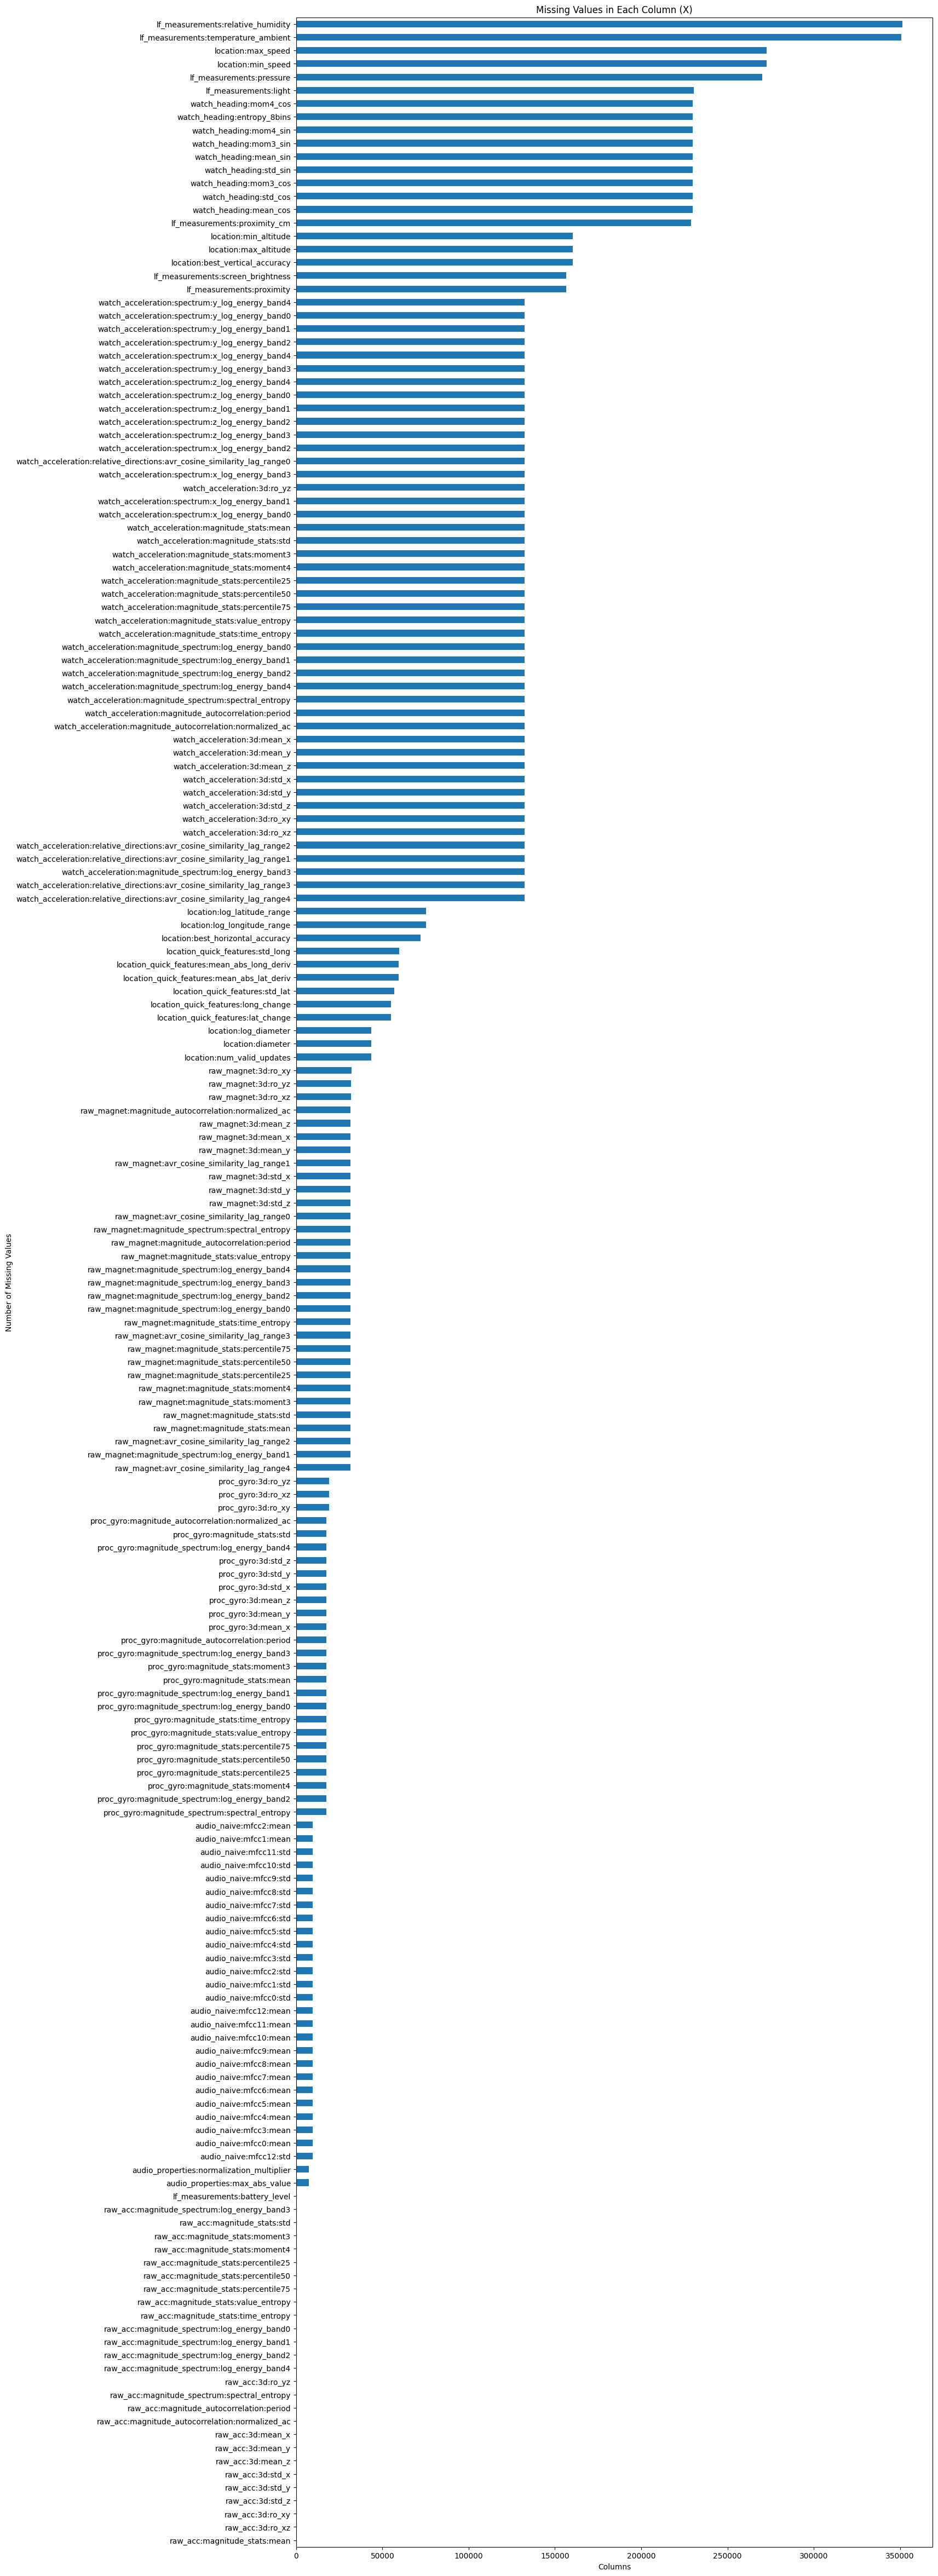

In [12]:
missing_value_check(X, 'X')

#TODO: Need to find the best way to add the missing values

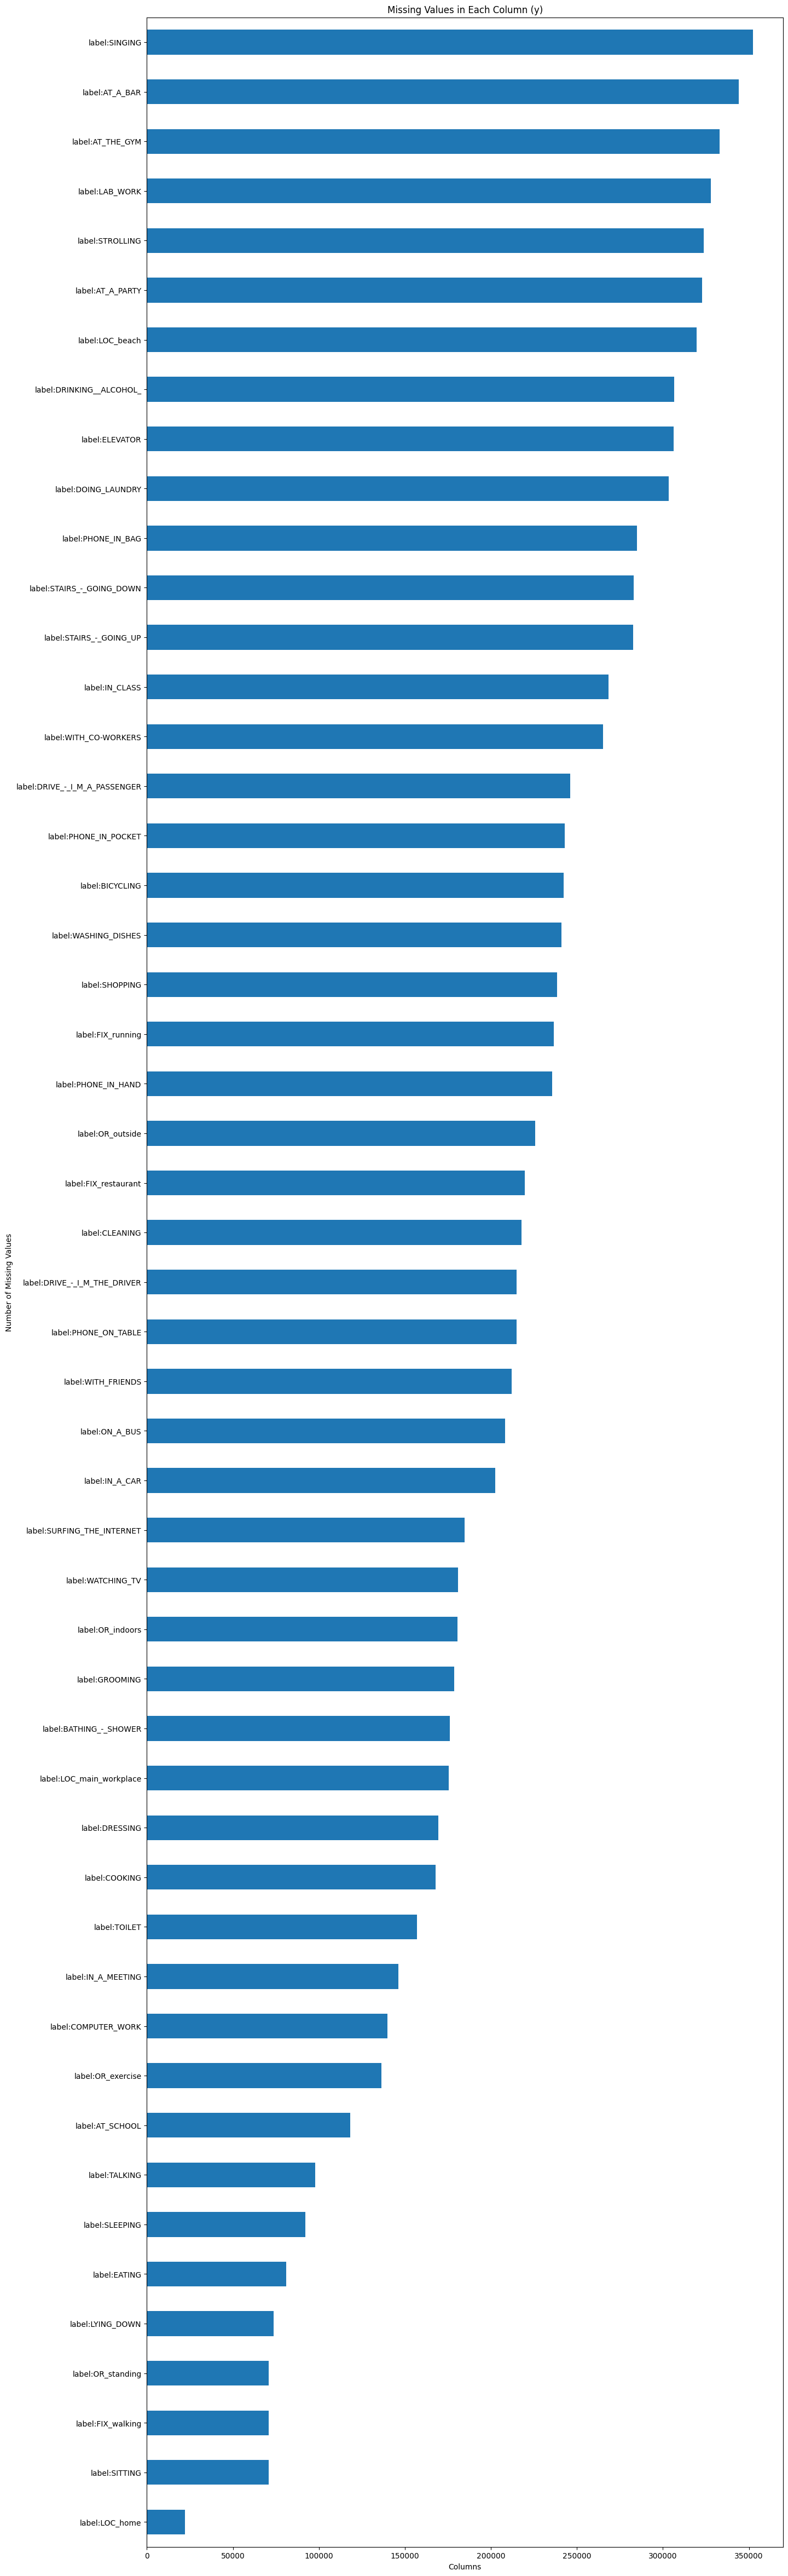

All the missing values have been covered.


/var/folders/8j/8zxjcfw125g4mfl6xvm5bl080000gn/T/ipykernel_76062/1312125286.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.fillna(0, inplace=True)


In [13]:
missing_value_check(y, 'y')
y.fillna(0, inplace=True)
missing_value_check(y, 'y')

In [14]:
# Assumption of Negatives: Replace NaN with 0 for label columns
label_columns = [col for col in y.columns if col.startswith("label:")]
y[label_columns] = y[label_columns].fillna(0)

# Recheck missing values percentage
def missing_value_check(df, df_name):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum() / df.isnull().count() * 100).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    print(f"Missing Values in {df_name}:\n", missing_data)

missing_value_check(y, 'y')

Missing Values in y:
                                Total  Percent
label:LYING_DOWN                   0      0.0
label:GROOMING                     0      0.0
label:WATCHING_TV                  0      0.0
label:SURFING_THE_INTERNET         0      0.0
label:AT_A_PARTY                   0      0.0
label:AT_A_BAR                     0      0.0
label:LOC_beach                    0      0.0
label:SINGING                      0      0.0
label:TALKING                      0      0.0
label:COMPUTER_WORK                0      0.0
label:EATING                       0      0.0
label:TOILET                       0      0.0
label:DRESSING                     0      0.0
label:DOING_LAUNDRY                0      0.0
label:AT_THE_GYM                   0      0.0
label:STAIRS_-_GOING_UP            0      0.0
label:STAIRS_-_GOING_DOWN          0      0.0
label:ELEVATOR                     0      0.0
label:OR_standing                  0      0.0
label:AT_SCHOOL                    0      0.0
label:PHONE_

/var/folders/8j/8zxjcfw125g4mfl6xvm5bl080000gn/T/ipykernel_76062/3709747393.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[label_columns] = y[label_columns].fillna(0)


## Time series linear regression for missing values in X

In [15]:
# Split data by user
data_by_user = {uid: df for uid, df in combined_csv_data.groupby('user_id')}

In [16]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Correctly check for NaN values
if X_imputed.isna().any().any():
    raise ValueError("Imputation failed, NaN values still present")

In [17]:
# Step 2 & 3: Predict and update original X with predictions
for column in X_imputed.select_dtypes(include=[np.number]).columns:
    # Splitting the dataset
    X_train = X_imputed.drop(columns=[column])
    y_train = X_imputed[column]
    
    # Identifying original missing values in X_imputed
    missing_mask = X_imputed[column].isna()
    
    # Only proceed if there are missing values to predict
    if missing_mask.any():
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        # Predicting for original missing values
        predictions = model.predict(X_imputed[missing_mask].drop(columns=[column]))
        
        # Step 4: Updating original X with predictions
        X_imputed.loc[missing_mask, column] = predictions

In [18]:
# Check missing value percentage
missing_percentage = (X_imputed.isna().mean() * 100).round(2)
print("Percentage of Missing Values:")
print(missing_percentage)

Percentage of Missing Values:
timestamp                                                                  0.0
raw_acc:magnitude_stats:mean                                               0.0
raw_acc:magnitude_stats:std                                                0.0
raw_acc:magnitude_stats:moment3                                            0.0
raw_acc:magnitude_stats:moment4                                            0.0
raw_acc:magnitude_stats:percentile25                                       0.0
raw_acc:magnitude_stats:percentile50                                       0.0
raw_acc:magnitude_stats:percentile75                                       0.0
raw_acc:magnitude_stats:value_entropy                                      0.0
raw_acc:magnitude_stats:time_entropy                                       0.0
raw_acc:magnitude_spectrum:log_energy_band0                                0.0
raw_acc:magnitude_spectrum:log_energy_band1                                0.0
raw_acc:magnitude_spec

## Model Comparison based on clean data

In [19]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

## Using LSTM prediction for missing values in X

In [15]:
# Split data by user
data_by_user = {uid: df for uid, df in combined_csv_data.groupby('user_id')}

In [17]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

normalized_data_by_user = {}
scalers_by_user = {}

for user_id, user_df in data_by_user.items():
    # Exclude non-numeric columns from scaling
    numeric_columns = user_df.select_dtypes(include=[np.number]).columns.tolist()

    # Handle missing values with forward fill for continuity in the time series
    user_df_filled = user_df[numeric_columns].fillna(method='ffill').fillna(method='bfill')

    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    user_df_scaled = scaler.fit_transform(user_df_filled)

    scalers_by_user[user_id] = scaler
    normalized_data_by_user[user_id] = user_df_scaled

n_features = len(numeric_columns)

/var/folders/8j/8zxjcfw125g4mfl6xvm5bl080000gn/T/ipykernel_35125/4034401930.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  user_df_filled = user_df[numeric_columns].fillna(method='ffill').fillna(method='bfill')
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:480: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:481: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/var/folders/8j/8zxjcfw125g4mfl6xvm5bl080000gn/T/ipykernel_35125/4034401930.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  user_df_filled = user_df[numeric_columns].fillna(method='ffill').fillna(method='bfill'

In [18]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

time_steps = 30  
n_features = 278 

# Define the LSTM model
model = Sequential([
    LSTM(units=50, input_shape=(time_steps, n_features), return_sequences=False),
    Dense(n_features)
])

model.compile(optimizer='adam', loss='mean_squared_error')


In [19]:
# Function to create sequences of data
def create_sequences(data, time_steps):
    Xs, ys = [], []
    for i in range(len(data) - time_steps):
        Xs.append(data[i:(i + time_steps)])
        ys.append(data[i + time_steps])
    return np.array(Xs), np.array(ys)

# Create sequences for each user and store them
X_by_user = {}
y_by_user = {}

for user_id, user_data in normalized_data_by_user.items():
    X, y = create_sequences(user_data, time_steps)
    X_by_user[user_id] = X
    y_by_user[user_id] = y

In [20]:
# loop through each user's data, train and validate the model
for user_id in X_by_user:
    X = X_by_user[user_id]
    y = y_by_user[user_id]
    
    # Split the dataset into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
    
    # Fit the model to the user's data
    model.fit(
        X_train, y_train,
        epochs=10, 
        batch_size=64, 
        validation_data=(X_val, y_val),
        verbose=1 
    )

Epoch 1/10
32/32 [==============================] - 2s 24ms/step - loss: nan - val_loss: nan
Epoch 2/10
32/32 [==============================] - 1s 16ms/step - loss: nan - val_loss: nan
Epoch 3/10
32/32 [==============================] - 1s 16ms/step - loss: nan - val_loss: nan
Epoch 4/10
32/32 [==============================] - 1s 16ms/step - loss: nan - val_loss: nan
Epoch 5/10
32/32 [==============================] - 1s 17ms/step - loss: nan - val_loss: nan
Epoch 6/10
32/32 [==============================] - 1s 17ms/step - loss: nan - val_loss: nan
Epoch 7/10
32/32 [==============================] - 1s 17ms/step - loss: nan - val_loss: nan
Epoch 8/10
32/32 [==============================] - 1s 17ms/step - loss: nan - val_loss: nan
Epoch 9/10
32/32 [==============================] - 1s 19ms/step - loss: nan - val_loss: nan
Epoch 10/10
32/32 [==============================] - 1s 18ms/step - loss: nan - val_loss: nan
Epoch 1/10
96/96 [==============================] - 2s 17ms/step - lo

KeyboardInterrupt: 